In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


# Loading the data

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

In [2]:
df = pd.read_csv("X_train1.csv")

# Exploration

In [3]:
df.shape

(18000, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

Doesn't seem like the time of transaction really matters.

# Autoencoders

Autoencoders can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it.

More specifically, let’s take a look at Autoencoder Neural Networks. This autoencoder tries to learn to approximate the following identity function:

$$\textstyle f_{W,b}(x) \approx x$$

While trying to do just that might sound trivial at first, it is important to note that we want to learn a compressed representation of the data, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called *undercomplete*.

Here's a visual representation of what an Autoencoder might learn:

![](http://curiousily.com/assets/12.what_to_do_when_data_is_missing_part_ii_files/mushroom_encoder.png)

## Reconstruction error

We optimize the parameters of our Autoencoder model in such way that a special kind of error - reconstruction error is minimized. In practice, the traditional squared error is often used:

$$\textstyle L(x,x') = ||\, x - x'||^2$$

# Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:

In [4]:
df.columns

Index([u'Doctor Identifier', u'Provider Type', u'Number of Services',
       u'Number of Beneficiaries', u'Total Submitted Charge Amount',
       u'Total Allowed Amount', u'Total Payment Amount',
       u'Total Standardized Payment Amount', u'Number of Drug Services',
       u'Total Drug Submitted Charge Amount', u'Total Drug Allowed Amount ',
       u'Total Drug Payment Amount ',
       u'Total Drug Standardized Payment Amount',
       u'Number of Medical Services', u'Percent Atrial Fibrillation',
       u'Percent Alzheimer’s Disease or Dementia ', u'Percent Asthma ',
       u'Percent Cancer ', u'Percent Heart Failure ',
       u'Percent Chronic Kidney Disease',
       u'Percent Chronic Obstructive Pulmonary Disease',
       u'Percent Depression ', u'Percent Diabetes ',
       u'Percent Hyperlipidemia ', u'Percent Hypertension ',
       u'Percent Ischemic Heart Disease ', u'Percent Osteoporosis ',
       u'Percent Rheumatoid Arthritis or Osteoarthritis ',
       u'Percent Schizophreni

In [5]:
from sklearn.preprocessing import StandardScaler

data = df.drop('Doctor Identifier', axis = 1)
data = pd.get_dummies(data, prefix=['Provider Type'])
data.head()

data_stand = (data - data.mean()) / (data.std())
data_stand = data_stand.fillna(-1)

#data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

# Building the model

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [6]:
X_train, X_test = train_test_split(data_stand, test_size=0.2, random_state=RANDOM_SEED)

In [7]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [8]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally,  the training progress will be exported in a format that TensorBoard understands.

In [9]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 14400 samples, validate on 3600 samples
Epoch 1/100
14400/14400 [==============================] - 2s 125us/step - loss: 0.9949 - acc: 0.1131 - val_loss: 0.8889 - val_acc: 0.2119
Epoch 2/100
14400/14400 [==============================] - 2s 142us/step - loss: 0.9453 - acc: 0.3124 - val_loss: 0.8561 - val_acc: 0.3797
Epoch 3/100
14400/14400 [==============================] - 2s 131us/step - loss: 0.9167 - acc: 0.4287 - val_loss: 0.8328 - val_acc: 0.4683
Epoch 4/100
14400/14400 [==============================] - 2s 131us/step - loss: 0.8950 - acc: 0.5148 - val_loss: 0.8149 - val_acc: 0.5486
Epoch 5/100
14400/14400 [==============================] - 2s 124us/step - loss: 0.8775 - acc: 0.5866 - val_loss: 0.7998 - val_acc: 0.5958
Epoch 6/100
14400/14400 [==============================] - 2s 147us/step - loss: 0.8625 - acc: 0.6153 - val_loss: 0.7868 - val_acc: 0.6331
Epoch 7/100
14400/14400 [==============================] - 2s 127us/step - loss: 0.8486 - acc: 0.6490 - val_loss: 0.7

14400/14400 [==============================] - 2s 129us/step - loss: 0.6668 - acc: 0.7288 - val_loss: 0.6165 - val_acc: 0.7150
Epoch 60/100
14400/14400 [==============================] - 2s 110us/step - loss: 0.6668 - acc: 0.7298 - val_loss: 0.6166 - val_acc: 0.7153
Epoch 61/100
14400/14400 [==============================] - 2s 112us/step - loss: 0.6647 - acc: 0.7289 - val_loss: 0.6159 - val_acc: 0.7150
Epoch 62/100
14400/14400 [==============================] - 2s 117us/step - loss: 0.6635 - acc: 0.7283 - val_loss: 0.6163 - val_acc: 0.7172
Epoch 63/100
14400/14400 [==============================] - 2s 133us/step - loss: 0.6618 - acc: 0.7297 - val_loss: 0.6134 - val_acc: 0.7161
Epoch 64/100
14400/14400 [==============================] - 2s 132us/step - loss: 0.6612 - acc: 0.7292 - val_loss: 0.6145 - val_acc: 0.7156
Epoch 65/100
14400/14400 [==============================] - 2s 140us/step - loss: 0.6605 - acc: 0.7289 - val_loss: 0.6106 - val_acc: 0.7164
Epoch 66/100
14400/14400 [=======

# Evaluation

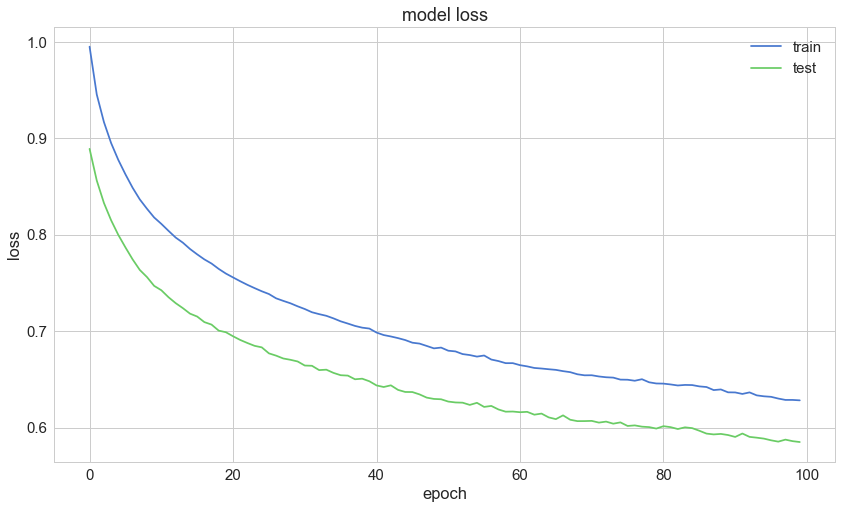

In [10]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [11]:
predictions = autoencoder.predict(X_test)

In [13]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

In [15]:
error_df

,reconstruction_error
2574,0.049007
7496,0.102058
9210,0.323978
5456,0.507377
736,0.148544
11770,1.236517
856,0.015145
7273,0.091632
11499,0.092921
11605,0.039848


In [21]:
predictions = autoencoder.predict(data_stand)
mse = np.mean(np.power(data_stand - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

In [22]:
submission = pd.DataFrame(df['Doctor Identifier'])
submission['Risk'] = error_df
submission.reset_index()
submission = submission.sort_values(['Risk'], ascending = False)

submission.to_csv('/Users/amilmerchant/challenge/autoencoder.csv', index = False, header = True)

In [23]:
print submission

       Doctor Identifier        Risk
12610          384220740  355.335804
6755           380670093  301.284513
754            130950711  159.397915
3420           215908907  159.339210
17852          188168150  147.216705
11072          817673436  122.298396
8434           654363204   79.718671
9690           420039785   79.695910
8685           922496134   65.343159
15669          431309789   53.376873
332            364118628   53.247362
10328          512508013   53.125163
11512          533296799   52.461348
15358          224372889   51.531887
5522           668089976   51.211478
14824          344674838   40.072718
8534           384519620   40.009513
6552           240397287   39.911683
3298           815655012   39.848418
4707           475278306   39.680833
17229          145726871   39.636684
6390           114153083   39.337294
10935          157503762   39.061861
16660          460420751   38.961923
9779           643217830   37.712898
1573           316827962   37.635444
1